In this study, i will use the data that i have collected from 3 supermarkets' web page. To collect the data, i used the scripts i have made in python and are public in my GitHub profile. 
I want to compare:
- The range of prices in each supermarkets for each kind of product, in order to know where can you find a better range of prices and cheapper.
- How the prices have varied in each date in each supermarket, because Argentina is a country with high inflaction.

First, i start by importing all the libraries needed.

In [1]:
!pip install dash plotly jupyter_dash -q

In [1]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import numpy as np

Then, i list all the products that are listed in the "basic basket" for each supermarkets."Basic basket" this is how in Argentina we refer to all the products that a family need to survive.

In [2]:
# All the products and categories i use to this study for each supermarket
basic_products_carrefour = {
    "arroz": [["arroz"]],
    "Pan" : [["pan", "de mesa"]],
    "aceites": [["aceite", "girasol"]],
    "pasta": [["fideos", "tirabuzon"]],
    "galletitas": [["galletitas", "crackers"]],
    "harinas": [["harina", "trigo"]],
    "verduras": [["papa"],["cebolla", "x kg"], ["zanahoria", "huella", "kg"]],
    "frutas": [["manzana"],["naranja"]],
    "conserva": [["lentejas"]],
    "vacuna": [["bife","chorizo"]],
    "sal": [["sal", "fina"]],
    "huevos": [["huevos"]],
    "leches": [["leche", "lt"]],
    "gaseosas": [["gaseosa"]]
}

basic_products_coto = {
    "arroz": [["arroz"]],
    "Pan" : [["pan", "de mesa"]],
    "aceites": [["aceite", "girasol"]],
    "pasta": [["fideos", "tirabuzon"]],
    "pan": [["galletitas", "crackers"]],
    "harinas": [["harina","trigo"]],
    "verduras": [["papa", "Xkg"],["cebolla","blanca" ,"kg"], ["zanahoria", "kg"]],
    "frutas": [["manzana", "comercial" ,"kg"],["naranja", "kg"]],
    "conserva": [["lentejas"]],
    "carniceria": [["bife","chorizo"]],
    "condimentos": [["sal", "fina"]],
    "huevos": [["huevos"]],
    "lácteos": [["leche", "L"]],
    "bebidas": [["gaseosa"]]
}

basic_products_dia = {
    "arroz": [["arroz"]],
    "Pan" : [["pan", "de molde"]],
    "aceites": [["aceite", "girasol"]],
    "pasta": [["fideos","tirabuzon"]],
    "galletitas": [["galletitas", "crackers"]],
    "harinas": [["harina","trigo"]],
    "verduras": [["papa"],["cebolla","kg"], ["zanahoria", "kg"]],
    "frutas": [["manzana"],["naranja"]],
    "conserva": [["lentejas"]],
    "carniceria": [["bife","chorizo"]],
    "aderezos": [["sal", "fina"]],
    "Frutas-y-verduras": [["huevos"]],
    "leches": [["leche", "Lt"]],
    "Gaseosas": [["gaseosa"]]
}

In the next block of code, i sumamarise the functions that will we use. This are:
- priceFormat to give a correct format to prices.
- filterDataFrame to use the category and product in the "basic basket" to return a dataframe with this information.
- obtainProductList to iter over all categories and product to create a dataframe with all products information.

In [3]:
def priceFormat(df):
    """
    In the DF the prices hace te format 1.000,00, this functions rewrites the prices
    in the "Prices" column in format 1000.00 
    """
    df["Price"] = df["Price"].str.replace(".", "").str.replace(",",".").astype(float)

def filterDataFrame(df, category_filter, product_filters):
    """
    This function use the categories and products in category_filter and product_filters
    to return a dataframe with the selected products
    """
    filtered_category = df[df["Category"].str.contains(category_filter, case=False, na=False)]
    mask = filtered_category["Product"].str.contains(product_filters[0], case=False, na=False)
    for product_filter in product_filters[1:]:
        mask &= filtered_category["Product"].str.contains(product_filter, case=False, na=False)

    filterd_products = filtered_category[mask]
    if filterd_products.empty:
        # If a product doesn"t match it means it is out of stock
        return pd.DataFrame([["NO STOCK", category_filter, np.nan]],columns=df.columns)
    return filterd_products

def  obtainProductList(df, products, supermarket):
    """
    Using the dataframe with all products and the filter for select producs,
    this function return a dataframe with the products that fit each category
    """
    df_out = pd.DataFrame()
    for category in products.keys():
        for product in products[category]:
            list_products = filterDataFrame(df, category, product)
            list_products["Product_type"] = product[0]
            if not df_out.empty:
                df_out = pd.concat([df_out, list_products], ignore_index=True)
            else:
                df_out = list_products
            
    df_out["Amount"] = 1
    df_out["Supermarket"] = supermarket
    return df_out

Then with the functions, i obtain all the dataframes for the most resent data for each supermarkets.

In [4]:
#Lastest data
carrefour_data = pd.read_csv("Supermarket_Data/Carrefour_Prices-27-12-2023.csv", sep=";")
coto_data = pd.read_csv("Supermarket_Data/Coto_Prices-29-12-2023.csv", sep=";")
dia_data = pd.read_csv("Supermarket_Data/Dia_Prices-27-12-2023.csv", sep=";")

priceFormat(carrefour_data)
priceFormat(coto_data)
priceFormat(dia_data)

selected_products_carrefour = obtainProductList(carrefour_data , basic_products_carrefour, "Carrefour")
selected_products_coto= obtainProductList(coto_data , basic_products_coto, "Coto")
selected_products_dia = obtainProductList(dia_data, basic_products_dia, "Dia")

#Final df with the selected products for each supermarket
df_products = pd.concat([selected_products_carrefour, selected_products_coto, selected_products_dia], ignore_index=True)

I made a dashboard to visualice and easily compare the range of prices for each category in the supermarkets.  
- It can be seen that, at least for this date 29/12/2023, Coto has the higher prices.  
- Carrefour and Dia has better prices.

In [5]:
#Get products type
types_products = df_products["Product_type"].unique()

app1 = dash.Dash(__name__)

app1.layout = html.Div([
    html.H1("Dashboard_1"),
    
    # The menu where we will select the product type
    dcc.Dropdown(
        id="tipo-dropdown-1",
        options=[
            {"label": tipo.capitalize(), "value": tipo} for tipo in types_products
        ],
        value=types_products[0],  
        style={
            "width": "50%",
            "text-align": "center"  
        }
    ),
    # Using boxplot
    dcc.Graph(id="boxplot-1", style={"height": "600px"}),
])

# Callback to update the boxplot
@app1.callback(
    Output("boxplot-1", "figure"),
    [Input("tipo-dropdown-1", "value")]
)
def update_boxplot(product):
    """
    This function use product to filter the data frame
    and then it returns a plot showing the data for that product
    """

    filtered_df = df_products[(df_products["Product_type"] == product)]
    
    fig = px.box(filtered_df, x="Supermarket", y="Price",
                color="Supermarket",
                boxmode="overlay"
                 )

    fig.update_layout(
        title=dict(text=f"Price in each supermarket for {product}", x=0.5, y=0.95),
        xaxis=dict(title="Supermarket"),
        yaxis=dict(title="Price [ARS$]"),
        showlegend = False,
        boxgap=0.01
    )
    return fig

app1.run_server(mode="external",port=8050)


Now, i obtain the ranges of prices which the full "basic basket" can cost. To obtain the lower limit, i sum all the cheaper products and to have the upper limit i sum the most expensive products.

In [6]:
result = df_products.groupby(["Supermarket", "Product_type"]).agg({"Price": ["min", "max"]}).reset_index()
result.columns = ["Supermarket", "Product_type", "Min_Price", "Max_Price"]
result = result.groupby("Supermarket").agg({"Min_Price": "sum", "Max_Price": "sum"}).reset_index()
result.columns = ["Supermarket", "Sum_Min_Price", "Sum_Max_Price"]

This barplot will show the ranges of prices that the "basic basket" can cost.
It can be seen in the graph, that Dia and Carrefour have almost the same range of prices, but Coto is a bit expensive but it have also a vast range of prices.

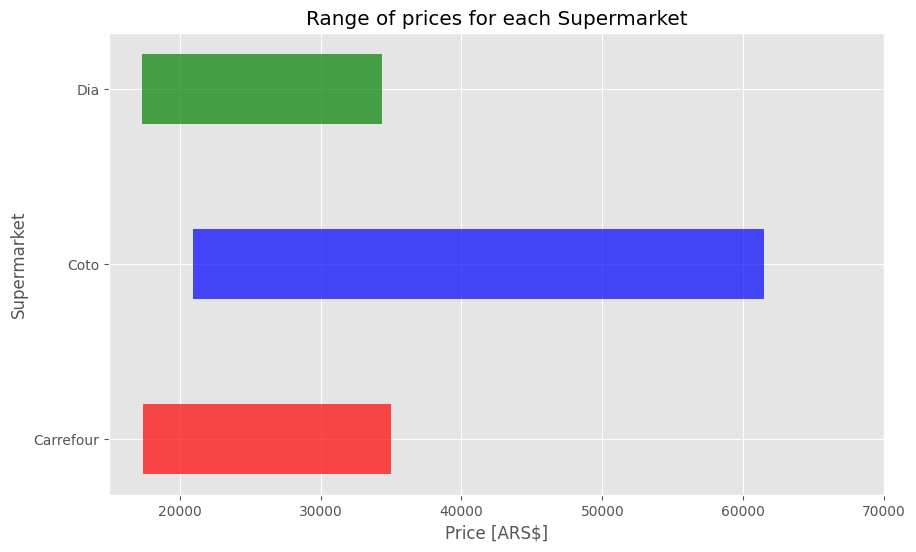

In [7]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["red", "blue", "green"]

i = 0
for index, row in result.iterrows():
    supermarket = row["Supermarket"]
    min_price = row["Sum_Min_Price"]
    max_price = row["Sum_Max_Price"]
    ax.barh(supermarket, width=max_price - min_price, left=min_price, height=0.4, color=colors[i], alpha=0.7)
    i += 1

ax.set_xlabel("Price [ARS$]")
ax.set_ylabel("Supermarket")
ax.set_title("Range of prices for each Supermarket")
ax.set_xlim(15000, 70000)  
plt.show()

Now, i use all dates data for each supermarket to see how the prices have gone up or down in this period of time.  
First, I start by finding all the files.

In [8]:
path_files = "Supermarket_Data/"
files = os.listdir(path_files)
csv_files = {
    "Carrefour":[],
    "Coto":[],
    "Dia":[ ]
}
for file in files:
    if "csv" in file:
        if "Carrefour" in file:
            date = file[-14:-4]
            csv_files["Carrefour"].append((path_files+file, date))
        elif "Coto" in file:
            date = file[-14:-4]
            csv_files["Coto"].append((path_files+file, date))
        elif "Dia" in file:
            date = file[-14:-4]
            csv_files["Dia"].append((path_files+file, date))

Then with dfAllTimeData, i prepare a dataframe with all the data belong to the supermarket  for each date.

In [9]:
def dfAllTimeData(dictionary, supermarket, products_selected):
    """
    This functions iter over all the CSV files from a supermarket 
    in the folder. Then filter them by the products selected 
    and return a dataframe with all the products for each date
    """

    df_list = []
    for category in products_selected.keys():
        for products in products_selected[category]:
            for csv_file, date in dictionary[supermarket]:
                df_data = pd.read_csv(csv_file, sep=";")
                priceFormat(df_data)
                list_products = filterDataFrame(df_data, category, products)
                list_products["Date"] = pd.to_datetime(date, format="%d-%m-%Y")
                list_products["Product_type"] = products[0]
                list_products["Supermarket"] = supermarket
                df_list.append(list_products)
    df_concatenado = pd.concat(df_list, keys=range(len(df_list)))
    df_concatenado = df_concatenado.reset_index(drop=True)
    df_concatenado = df_concatenado.sort_values(by="Date")
    return df_concatenado

Then, i make the dataframes for each supermarket and concat them

In [10]:
selected_carrefour_data = dfAllTimeData(csv_files, "Carrefour", basic_products_carrefour)
selected_coto_data =  dfAllTimeData(csv_files, "Coto", basic_products_coto)
selected_dia_data = dfAllTimeData(csv_files, "Dia", basic_products_dia)

selected_data_all = pd.concat([selected_carrefour_data, selected_coto_data, selected_dia_data], ignore_index=True)

Finally, i make a dashboard summarise how the prices have varied  for each product in a supermarket.

In [11]:
#Get products type and supermarket
types_products = selected_data_all["Product_type"].unique()
supermarkets = selected_data_all["Supermarket"].unique()

app2 = dash.Dash(__name__)

app2.layout = html.Div([
    html.H1("Dashboard-2"),
    
    #Each menu to select product and supermarket
    dcc.Dropdown(
        id="tipo-dropdown-1-2",
        options=[
            {"label": tipo.capitalize(), "value": tipo} for tipo in types_products
        ],
        value=types_products[0],  
        style={
            "width": "50%",
            "text-align": "center"  
        }
    ),
    dcc.Dropdown(
        id="tipo-dropdown-2-2",
        options=[
            {"label": tipo.capitalize(), "value": tipo} for tipo in supermarkets
        ],
        value=supermarkets[0],  
        style={
            "width": "50%",
            "text-align": "center",  
        }
    ),
    # Boxplot
    dcc.Graph(id="boxplot-2"),
])

# Callback to update the boxplot
@app2.callback(
    Output("boxplot-2", "figure"),
    [Input("tipo-dropdown-1-2", "value")],
    [Input("tipo-dropdown-2-2", "value")]
)
def update_boxplot(product, supermarket):
    """
    This function use product and supermarket to filter the data frame
    and then it returns a plot showing the data for that product
    """
    filtered_df = selected_data_all[(selected_data_all["Product_type"] == product) & (selected_data_all["Supermarket"] == supermarket)].copy()
    
    filtered_df["Date"] = filtered_df["Date"].dt.strftime("%d/%m/%Y")

    fig = px.box(filtered_df, x="Date", y="Price",
                 color = "Date")  
    
    fig.update_xaxes(type="category", tickmode="array", tickformat="%d/%m/%Y")
    
    fig.update_layout(
        title=dict(text=f"Price per Date for {product} in {supermarket}", x=0.5, y=0.95),
        xaxis=dict(title="Date"),
        yaxis=dict(title="Price [ARS$]"),
        boxmode="overlay",  
        boxgap=0.05,       
        boxgroupgap=0.05,
        showlegend = False
    )

    return fig

app2.run_server(mode="external",port=8051)


Now I want to know the average prices of each product and how much the average prices have increased compared to the previous data.

In [13]:
price_resumen = selected_data_all.groupby(["Supermarket", "Product_type", "Date"])["Price"].mean().reset_index()

price_resumen = price_resumen.sort_values(by=["Supermarket", "Product_type", "Date"])

price_resumen["Price_last_date"] = price_resumen.groupby(["Supermarket", "Product_type"])["Price"].shift(1)
price_resumen["Price_last_date"] = price_resumen.groupby(["Supermarket", "Product_type"])["Price_last_date"].ffill()


price_resumen["Price_porcentual_change"] = round(100*(price_resumen["Price"] - price_resumen["Price_last_date"])/price_resumen["Price_last_date"],1)
price_resumen["Price_porcentual_change"] = price_resumen["Price_porcentual_change"].fillna(1.0)
price_resumen["Price_porcentual_change"] = price_resumen["Price_porcentual_change"].replace([np.inf, -np.inf], 1.0)
price_resumen["Price_porcentual_change"] = price_resumen["Price_porcentual_change"].replace(0, 1.0)

price_resumen = price_resumen.drop("Price_last_date", axis = 1)


Then, i make a dashboard to summarise how the mean prices have incresed or decreased for each product in a supermarket

In [14]:
#Get products type and supermarket
types_products = price_resumen["Product_type"].unique()
supermarkets = price_resumen["Supermarket"].unique()

app3 = dash.Dash(__name__)

app3.layout = html.Div([
    html.H1("Dashboard-3"),
    
    #Each menu to select product and supermarket
    dcc.Dropdown(
        id="tipo-dropdown-1-3",
        options=[
            {"label": tipo.capitalize(), "value": tipo} for tipo in types_products
        ],
        value=types_products[0],  
        style={
            "width": "50%",
            "text-align": "center"  
        }
    ),
    dcc.Dropdown(
        id="tipo-dropdown-2-3",
        options=[
            {"label": tipo.capitalize(), "value": tipo} for tipo in supermarkets
        ],
        value=supermarkets[0],  
        style={
            "width": "50%",
            "text-align": "center",  
        }
    ),
    # Barplot
    dcc.Graph(id="barplot"),
])

# Callback to update the boxplot
@app3.callback(
    Output("barplot", "figure"),
    [Input("tipo-dropdown-1-3", "value")],
    [Input("tipo-dropdown-2-3", "value")]
)
def update_boxplot(product, supermarket):
    """
    This function use product and supermarket to filter the data frame
    and then it returns a plot showing the data for that product
    """
    filtered_df = price_resumen[(price_resumen["Product_type"] == product) & (price_resumen["Supermarket"] == supermarket)].copy()
    
    filtered_df["Date"] = filtered_df["Date"].dt.strftime("%d/%m/%Y")
    filtered_df["text"] = filtered_df["Price_porcentual_change"].apply(lambda x: f"Change: {x:.2f}%")

    fig = px.bar(filtered_df, x="Date", y="Price", color="Date", text="text")  
    
    fig.update_xaxes(type="category", tickmode="array", tickformat="%d/%m/%Y")
    
    fig.update_layout(
        title=dict(text=f"Mean price per Date for {product} in {supermarket}", x=0.5, y=0.95),
        xaxis=dict(title="Date"),
        yaxis=dict(title="Price [ARS$]"),
        bargap=0.05,       
        bargroupgap=0.05,
        showlegend=False   
    )

    return fig

app3.run_server(mode="external",port=8052)



Finally, i calculate the mean cumulative inflation for each supermarket, this will show us how much in average the products prices have increase in this period of time.  
It can be seen that the product have incresed in, at least, 20% in each supermarkets. In Dia, the product have increased more.

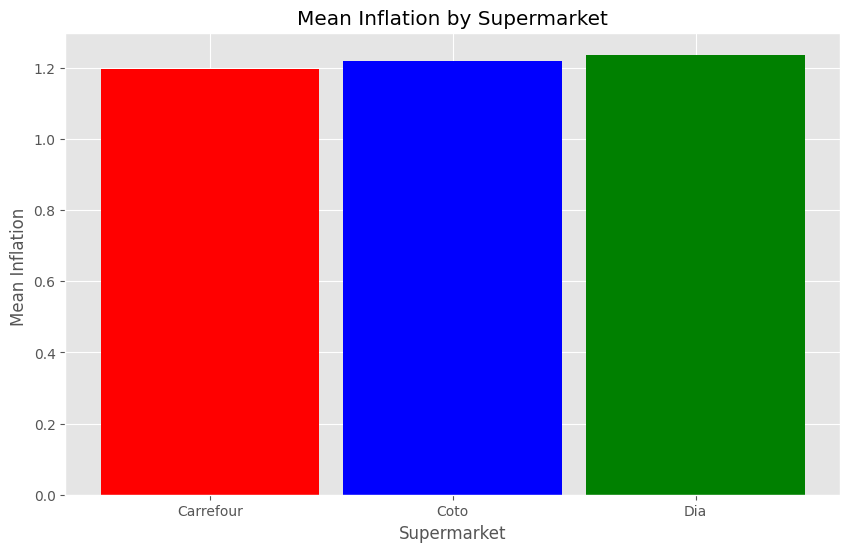

In [15]:
price_resumen["Price_change"] = (1 + price_resumen["Price_porcentual_change"]/100)
price_resumen["acumulates_inflation"] = price_resumen.groupby(["Supermarket", "Product_type"])["Price_change"].cumprod()
mean_inflation = price_resumen.groupby(["Supermarket"])["acumulates_inflation"].mean().reset_index()


plt.style.use("ggplot")

plt.figure(figsize=(10, 6))

bars = plt.bar(mean_inflation["Supermarket"], mean_inflation["acumulates_inflation"], color= ["red", "blue", "green"], width=0.9)

plt.title("Mean Inflation by Supermarket")
plt.xlabel("Supermarket")
plt.ylabel("Mean Inflation ")
plt.xticks(rotation=0, ha="center") 

plt.show()